# Construct the gene regulatory network

## Load data

### Download the general gene regulatory network

We provide the general gene regulatory network, please download the data first.  

Datadir=/path/to/LINGER/# the directory to store the data please use the absolute directory. Example:   Datadir=/zfs/durenlab/palmetto/Kaya/SC_NET/code/github/combine/data/  
mkdir Datadir    
cd Datadir  
wget --load-cookies /tmp/cookies.txt "https://drive.usercontent.google.com/download?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.usercontent.google.com/download?id=1lAlzjU5BYbpbr4RHMlAGDOh9KWdCMQpS'  -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lAlzjU5BYbpbr4RHMlAGDOh9KWdCMQpS" -O data_bulk.tar.gz && rm -rf /tmp/cookies.txt  

Then unzip:  
tar -xzf data_bulk.tar.gz  

这部分数据我已经在之前的PBMC教程中下载完了

### Input data
The input data should be anndata format. In this example, we need to transfer the following data type to anndata：  
1. Single-cell multiome data including gene expression (RNA.txt in our example) and chromatin accessibility (ATAC.txt in our example).  
2. Cell annotation/cell type label if you need the cell type specific gene regulatory network (label.txt in our example).   

RNA-seq
The row of RNA-seq is gene symbol; the column is the barcode; the value is the count matrix. Here is our example:
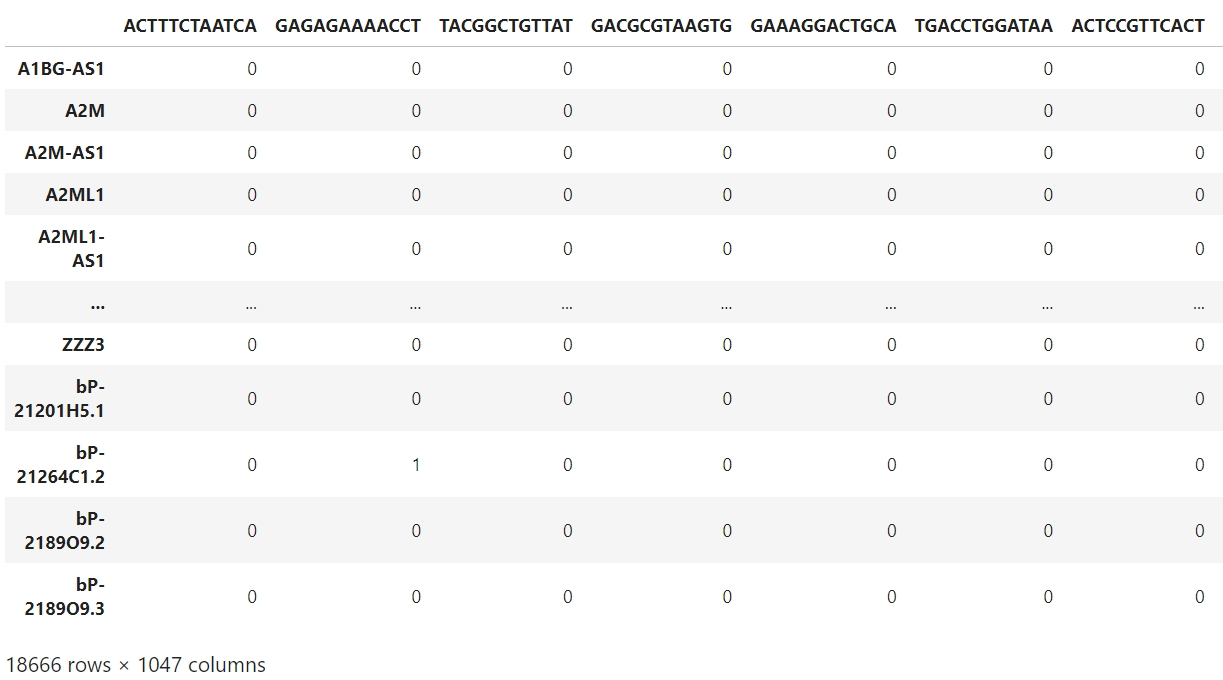

ATAC-seq
The row is the regulatory element/genomic region; the column is the barcode, which is in the same order as RNA-seq data; the value is the count matrix. Here is our example:
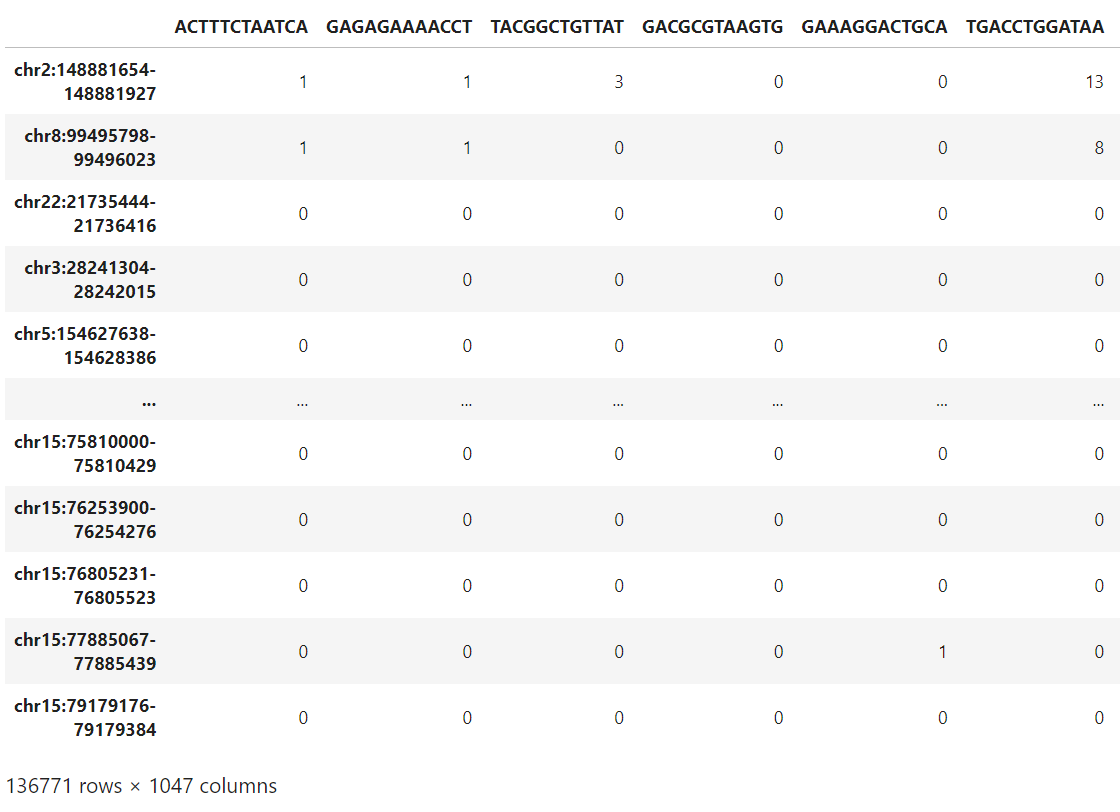

Cell annotation/cell type label
The row is cell barcode, which is the same order with RNA-seq data; there is one column 'Annotation', which is the cell type label. It could be a number or the string. Here is our example:
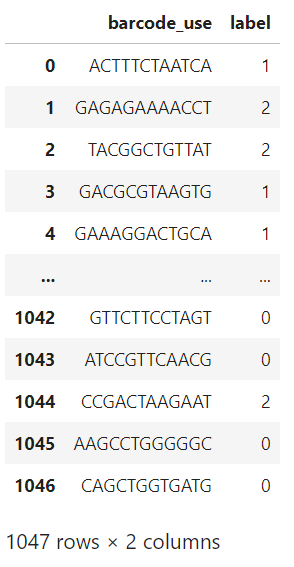


### Provided input example
You can download the example input datasets into a certain directory. This sc multiome data of an in-silico mixture of H1, BJ, GM12878, and K562 cell lines from droplet-based single-nucleus chromatin accessibility and mRNA expression sequencing (SNARE-seq) data.  

Input_dir=/path/to/dir/  
#The input data directory. Example: Input_dir=/zfs/durenlab/palmetto/Kaya/SC_NET/code/github/combine/LINGER/examples/  
cd $Input_dir  
#ATAC-seq  
wget --load-cookies /tmp/cookies.txt "https://drive.usercontent.google.com/download?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.usercontent.google.com/download?id=1qmMudeixeRbYS8LCDJEuWxlAgeM0hC1r'  -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qmMudeixeRbYS8LCDJEuWxlAgeM0hC1r" -O ATAC.txt && rm -rf /tmp/cookies.txt  
#RNA-seq  
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dP4ITjQZiVDa52xfDTo5c14f9H0MsEGK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dP4ITjQZiVDa52xfDTo5c14f9H0MsEGK" -O RNA.txt && rm -rf /tmp/cookies.txt  
#label  
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZeEp5GnWfQJxuAY0uK9o8s_uAvFsNPI5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZeEp5GnWfQJxuAY0uK9o8s_uAvFsNPI5" -O label.txt && rm -rf /tmp/cookies.txt  

## LINGER

### Install

略  之前教程的时候已经安装好了

### Preprocess
There are 2 options of the method we introduced above:


In [1]:
#1.baseline：
method='baseline' # this is corresponding to bulkNN

In [1]:
#2.LINGER;
method='LINGER'

#### Tansfer sc-multiome data to anndata

如果要重新跑 这一段要跑

In [2]:
import pandas as pd

RNA=pd.read_csv('inputdata/RNA.txt',sep='\t',header=0,index_col=0)
ATAC=pd.read_csv('inputdata/ATAC.txt',sep='\t',header=0,index_col=0)
from scipy.sparse import csc_matrix
# Convert the NumPy array to a sparse csc_matrix
matrix = csc_matrix(pd.concat([RNA,ATAC],axis=0).values)
features=pd.DataFrame(RNA.index.tolist()+ATAC.index.tolist(),columns=[1])
K=RNA.shape[0]
N=K+ATAC.shape[0]
types = ['Gene Expression' if i <= K else 'Peaks' for i in range(0, N)]
features[2]=types
barcodes=pd.DataFrame(RNA.columns.values,columns=[0])


In [3]:
# 读取 label 数据框，跳过无效的第一行
label = pd.read_csv('inputdata/label.txt', sep='\t', header=None, names=['barcode_use', 'label'], skiprows=[0])
# 设置 barcode_use 为索引
label = label.set_index('barcode_use')

label['barcode_use'] = label.index

In [4]:
print(label.columns)  # 打印 label 数据框的列名
print(label.head())   # 打印 label 数据框的前几行

Index(['label', 'barcode_use'], dtype='object')
              label   barcode_use
barcode_use                      
ACTTTCTAATCA      1  ACTTTCTAATCA
GAGAGAAAACCT      2  GAGAGAAAACCT
TACGGCTGTTAT      2  TACGGCTGTTAT
GACGCGTAAGTG      1  GACGCGTAAGTG
GAAAGGACTGCA      1  GAAAGGACTGCA


In [5]:
label

,label,barcode_use
barcode_use,,
ACTTTCTAATCA,1,ACTTTCTAATCA
GAGAGAAAACCT,2,GAGAGAAAACCT
TACGGCTGTTAT,2,TACGGCTGTTAT
GACGCGTAAGTG,1,GACGCGTAAGTG
GAAAGGACTGCA,1,GAAAGGACTGCA
...,...,...
GTTCTTCCTAGT,0,GTTCTTCCTAGT
ATCCGTTCAACG,0,ATCCGTTCAACG
CCGACTAAGAAT,2,CCGACTAAGAAT


In [6]:
from LingerGRN.preprocess import *
adata_RNA,adata_ATAC=get_adata(matrix,features,barcodes,label)# adata_RNA and adata_ATAC are scRNA and scATA

/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/LingerGRN/preprocess.py:278: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_RNA.obs['label']=label.loc[adata_RNA.obs['barcode']]['label'].values
/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/LingerGRN/preprocess.py:281: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ATAC.obs['label']=label.loc[adata_ATAC.obs['barcode']]['label'].values


#### Remove low counts cells and genes

如果要重新跑 这一段要跑

In [7]:
import scanpy as sc
sc.pp.filter_cells(adata_RNA, min_genes=200)
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.filter_cells(adata_ATAC, min_genes=200)
sc.pp.filter_genes(adata_ATAC, min_cells=3)
selected_barcode=list(set(adata_RNA.obs['barcode'].values)&set(adata_ATAC.obs['barcode'].values))
barcode_idx=pd.DataFrame(range(adata_RNA.shape[0]), index=adata_RNA.obs['barcode'].values)
adata_RNA = adata_RNA[barcode_idx.loc[selected_barcode][0]]
barcode_idx=pd.DataFrame(range(adata_ATAC.shape[0]), index=adata_ATAC.obs['barcode'].values)
adata_ATAC = adata_ATAC[barcode_idx.loc[selected_barcode][0]]

/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


#### Generate the pseudo-bulk/metacell

In [9]:
from LingerGRN.pseudo_bulk import *
samplelist=list(set(adata_ATAC.obs['sample'].values)) # sample is generated from cell barcode 
tempsample=samplelist[0]
TG_pseudobulk=pd.DataFrame([])
RE_pseudobulk=pd.DataFrame([])
singlepseudobulk = (adata_RNA.obs['sample'].unique().shape[0]*adata_RNA.obs['sample'].unique().shape[0]>100)
for tempsample in samplelist:
    adata_RNAtemp=adata_RNA[adata_RNA.obs['sample']==tempsample]
    adata_ATACtemp=adata_ATAC[adata_ATAC.obs['sample']==tempsample]
    TG_pseudobulk_temp,RE_pseudobulk_temp=pseudo_bulk(adata_RNAtemp,adata_ATACtemp,singlepseudobulk)                
    TG_pseudobulk=pd.concat([TG_pseudobulk, TG_pseudobulk_temp], axis=1)
    RE_pseudobulk=pd.concat([RE_pseudobulk, RE_pseudobulk_temp], axis=1)
    RE_pseudobulk[RE_pseudobulk > 100] = 100

import os
if not os.path.exists('data/'):
    os.mkdir('data/')
adata_ATAC.write('data/adata_ATAC.h5ad')
adata_RNA.write('data/adata_RNA.h5ad')
TG_pseudobulk=TG_pseudobulk.fillna(0)
RE_pseudobulk=RE_pseudobulk.fillna(0)
pd.DataFrame(adata_ATAC.var['gene_ids']).to_csv('data/Peaks.txt',header=None,index=None)
TG_pseudobulk.to_csv('data/TG_pseudobulk.tsv')
RE_pseudobulk.to_csv('data/RE_pseudobulk.tsv')

/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import 

### Training model
Overlap the region with general GRN:

In [10]:
import pybedtools
pybedtools.helpers.set_bedtools_path("/disk1/cai026/mambaforge/envs/LINGER/bin")  # 替换为实际路径
#为了解决NotImplementedError: "intersectBed" does not appear to be installed or on the path, so this method is disabled.  Please install a more recent version of BEDTools and re-import to use this method.

In [13]:
from LingerGRN.preprocess import *
Datadir='/disk1/cai026/LINGER/Datadir/'# This directory should be the same as Datadir defined in the above 'Download the general gene regulatory network' section
GRNdir=Datadir+'data_bulk/'
genome='hg38'
outdir='/disk1/cai026/LINGER/Tutorial/H1output/' #output dir 最后一定要加一个斜杠
preprocess(TG_pseudobulk,RE_pseudobulk,GRNdir,genome,method,outdir)

Mapping gene expression...
Generate TF expression...
Generate RE chromatin accessibility...
Generate TF binding...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [05:11<00:00, 13.56s/it]


Generate Index...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11165/11165 [00:11<00:00, 953.06it/s]


Train for the LINGER model.

In [14]:
import LingerGRN.LINGER_tr as LINGER_tr
activef='ReLU' # active function chose from 'ReLU','sigmoid','tanh'
LINGER_tr.training(GRNdir,method,outdir,activef,'Human')

chr1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1159/1159 [13:13<00:00,  1.46it/s]


chr2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 773/773 [07:58<00:00,  1.61it/s]


chr3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 670/670 [32:24<00:00,  2.90s/it]


chr4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 443/443 [22:48<00:00,  3.09s/it]


chr5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [20:16<00:00,  2.27s/it]


chr6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 575/575 [05:59<00:00,  1.60it/s]


chr7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 519/519 [04:09<00:00,  2.08it/s]


chr8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 394/394 [03:22<00:00,  1.94it/s]


chr9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [03:28<00:00,  2.23it/s]


chr10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [03:53<00:00,  1.91it/s]


chr11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 637/637 [05:29<00:00,  1.93it/s]


chr12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [06:39<00:00,  1.50it/s]


chr13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [01:32<00:00,  2.23it/s]


chr14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [02:28<00:00,  2.46it/s]


chr15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [02:27<00:00,  2.41it/s]


chr16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [03:32<00:00,  2.29it/s]


chr17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 594/594 [05:06<00:00,  1.94it/s]


chr18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [01:17<00:00,  2.19it/s]


chr19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [06:08<00:00,  1.98it/s]


chr20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 296/296 [03:12<00:00,  1.54it/s]


chr21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:31<00:00,  3.41it/s]


chr22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [02:49<00:00,  1.44it/s]


chrX


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [03:00<00:00,  2.21it/s]


### Cell population gene regulatory network

**TF binding potential**  
The output is 'cell_population_TF_RE_binding.txt', a matrix of the TF-RE binding score.

In [16]:
import LingerGRN.LL_net as LL_net
LL_net.TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)

Generating cellular population TF binding strength ...


  0%|                                                                                                                                                                                   | 0/23 [00:00<?, ?it/s]

Generating cellular population TF binding strength for chr1



  4%|███████▍                                                                                                                                                                  | 1/23 [01:54<41:50, 114.11s/it]

Generating cellular population TF binding strength for chr2



  9%|██████████████▊                                                                                                                                                            | 2/23 [02:54<28:48, 82.30s/it]

Generating cellular population TF binding strength for chr3



 13%|██████████████████████▎                                                                                                                                                    | 3/23 [03:41<22:08, 66.42s/it]

Generating cellular population TF binding strength for chr4



 17%|█████████████████████████████▋                                                                                                                                             | 4/23 [04:04<15:34, 49.20s/it]

Generating cellular population TF binding strength for chr5



 22%|█████████████████████████████████████▏                                                                                                                                     | 5/23 [04:43<13:42, 45.68s/it]

Generating cellular population TF binding strength for chr6



 26%|████████████████████████████████████████████▌                                                                                                                              | 6/23 [05:29<12:57, 45.71s/it]

Generating cellular population TF binding strength for chr7



 30%|████████████████████████████████████████████████████                                                                                                                       | 7/23 [06:16<12:17, 46.10s/it]

Generating cellular population TF binding strength for chr8



 35%|███████████████████████████████████████████████████████████▍                                                                                                               | 8/23 [06:42<09:55, 39.70s/it]

Generating cellular population TF binding strength for chr9



 39%|██████████████████████████████████████████████████████████████████▉                                                                                                        | 9/23 [07:34<10:07, 43.37s/it]

Generating cellular population TF binding strength for chr10



 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                | 10/23 [08:03<08:28, 39.08s/it]

Generating cellular population TF binding strength for chr11



 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 11/23 [09:12<09:39, 48.27s/it]

Generating cellular population TF binding strength for chr12



 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 12/23 [10:03<08:59, 49.05s/it]

Generating cellular population TF binding strength for chr13



 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 13/23 [10:17<06:24, 38.49s/it]

Generating cellular population TF binding strength for chr14



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 14/23 [10:44<05:14, 34.97s/it]

Generating cellular population TF binding strength for chr15



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 15/23 [11:19<04:40, 35.02s/it]

Generating cellular population TF binding strength for chr16



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 16/23 [12:10<04:39, 39.87s/it]

Generating cellular population TF binding strength for chr17



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 17/23 [13:25<05:02, 50.43s/it]

Generating cellular population TF binding strength for chr18



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 18/23 [13:37<03:13, 38.68s/it]

Generating cellular population TF binding strength for chr19



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 19/23 [15:39<04:15, 63.77s/it]

Generating cellular population TF binding strength for chr20



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 20/23 [16:17<02:48, 56.23s/it]

Generating cellular population TF binding strength for chr21



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/23 [16:27<01:24, 42.30s/it]

Generating cellular population TF binding strength for chr22



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 22/23 [17:09<00:42, 42.03s/it]

Generating cellular population TF binding strength for chrX



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [17:33<00:00, 45.81s/it]


**cis-regulatory network**  
The output is 'cell_population_cis_regulatory.txt' with 3 columns: region, target gene, cis-regulatory score.

In [17]:
LL_net.cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 15/23 [00:24<00:09,  1.19s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:34<00:00,  1.50s/it]


**trans-regulatory network**  
The output is 'cell_population_trans_regulatory.txt', a matrix of the trans-regulatory score.

In [18]:
LL_net.trans_reg(GRNdir,method,outdir,genome)

Generate trans-regulatory netowrk ...


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 14/23 [00:12<00:06,  1.40it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:20<00:00,  1.12it/s]


Save trans-regulatory netowrk ...


### Cell type sepecific gene regulaory network
There are 2 options:

1. infer GRN for a specific cell type, which is in the label.txt;

In [19]:
celltype='0'#use a string to assign your cell type

2. infer GRNs for all cell types.

In [6]:
celltype='all'
#Please make sure that 'all' is not a cell type in your data.

**TF binding potential**  
The output is 'cell_population_TF_RE_binding_celltype.txt', a matrix of the TF-RE binding potential.

In [21]:
LL_net.cell_type_specific_TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,celltype,outdir,method)

  0%|                                                                                                                                                                                   | 0/23 [00:00<?, ?it/s]elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  4%|███████▍                                                                                                                                                                   | 1/23 [00:21<07:52, 21.49s/it]elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  9%|██████████████▊                                                                                                                          

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 19/23 [03:02<00:37,  9.38s/it]elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 20/23 [03:08<00:25,  8.37s/it]elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

**cis-regulatory network**  
The output is 'cell_type_specific_cis_regulatory_{celltype}.txt' with 3 columns: region, target gene, cis-regulatory score.

In [22]:
LL_net.cell_type_specific_cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,celltype,outdir,method)

  0%|                                                                                                                                                                                   | 0/23 [00:00<?, ?it/s]elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  4%|███████▍                                                                                                                                                                   | 1/23 [00:03<01:07,  3.09s/it]elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  9%|██████████████▊                                                                                                                          

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 19/23 [00:27<00:10,  2.56s/it]elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 20/23 [00:28<00:05,  1.95s/it]elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

**trans-regulatory network**  
The output is 'cell_type_specific_trans_regulatory_{celltype}.txt', a matrix of the trans-regulatory score.

In [23]:
LL_net.cell_type_specific_trans_reg(GRNdir,adata_RNA,celltype,outdir)

## Note
1. The cell specific GRN is based on the output of the cell population GRN.
2. If we want to try 2 different method options, we can create 2 output directory.

## Identify driver regulators by TF activity
下游应用
### Instruction
TF activity, focusing on the DNA-binding component of TF proteins in the nucleus, is a more reliable metric than mRNA or whole protein expression for identifying driver regulators. Here, we employed LINGER inferred GRNs from sc-multiome data of a single individual. Assuming the GRN structure is consistent across individuals, we estimated TF activity using gene expression data alone. By comparing TF activity between cases and controls, we identified driver regulators.  
与 mRNA 或整个蛋白质的表达相比，TF 活性是识别驱动调节因子的一个更可靠的指标。在这里，我们利用 LINGER 从单个个体的 sc-multiome 数据中推断出 GRN。假定不同个体的 GRN 结构是一致的，我们仅使用基因表达数据来估计 TF 活性。通过比较病例和对照组的 TF 活性，我们确定了驱动调节因子。

### Prepare
We need to trans-regulatory network, you can choose a network match you data best.

1. If there is not single cell avaliable to infer the cell population and cell type specific GRN, you can choose a GRN from various tissues.
没有标注好的数据

In [ ]:
network = 'general'

2. If your gene expression data are matched with cell population GRN, you can set

In [24]:
network = 'cell population'

3. If your gene expression data are matched with certain cell type, you can set network to the name of this cell type.

In [25]:
network = '0' # 0 is the name of one cell type

### Calculate TF activity  
The input is gene expression data, It could be the scRNA-seq data from the sc multiome data. It could be other sc or bulk RNA-seq data matches the GRN. The row of gene expresion data is gene, columns is sample and the value is read count (sc) or FPKM/RPKM (bulk).  
输入是基因表达数据，可以是 sc 多组数据中的 scRNA-seq 数据。也可能是与 GRN 匹配的其他 sc 或批量 RNA-seq 数据。基因表达数据的行为基因，列为样本，值为读数（sc）或 FPKM/RPKM（bulk）。

In [26]:
import anndata
from LingerGRN.TF_activity import *
Datadir='/disk1/cai026/LINGER/Datadir/'# This directory should be the same as Datadir defined in the above 'Download the general gene regulatory network' section
GRNdir=Datadir+'data_bulk/'
genome='hg38'
outdir='/disk1/cai026/LINGER/Tutorial/H1output/' #output dir 最后一定要加一个斜杠

adata_RNA=anndata.read_h5ad('data/adata_RNA.h5ad')
TF_activity=regulon(outdir,adata_RNA,GRNdir,network,genome)


In [ ]:
#这个不要跑  跑上面这个就可以了

Datadir='/zfs/durenlab/palmetto/Kaya/SC_NET/code/github/combine/'# this directory should be the same with Datadir
GRNdir=Datadir+'data_bulk/'
genome='hg38'
from LingerGRN.TF_activity import *
outdir='/zfs/durenlab/palmetto/Kaya/SC_NET/code/github/combine/LINGER/examples/output/' #output dir
import anndata
adata_RNA=anndata.read_h5ad('data/adata_RNA.h5ad')
TF_activity=regulon(outdir,adata_RNA,GRNdir,network,genome)

#这里因为找不到adata_RNA.h5ad  所以直接把上面的adata_RNA拿来用了

Visualize the TF activity heatmap by cluster. If you want to save the heatmap to outdit, please set 'save=True'. The output is 'heatmap_activity.png'.

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 800x600 with 0 Axes>

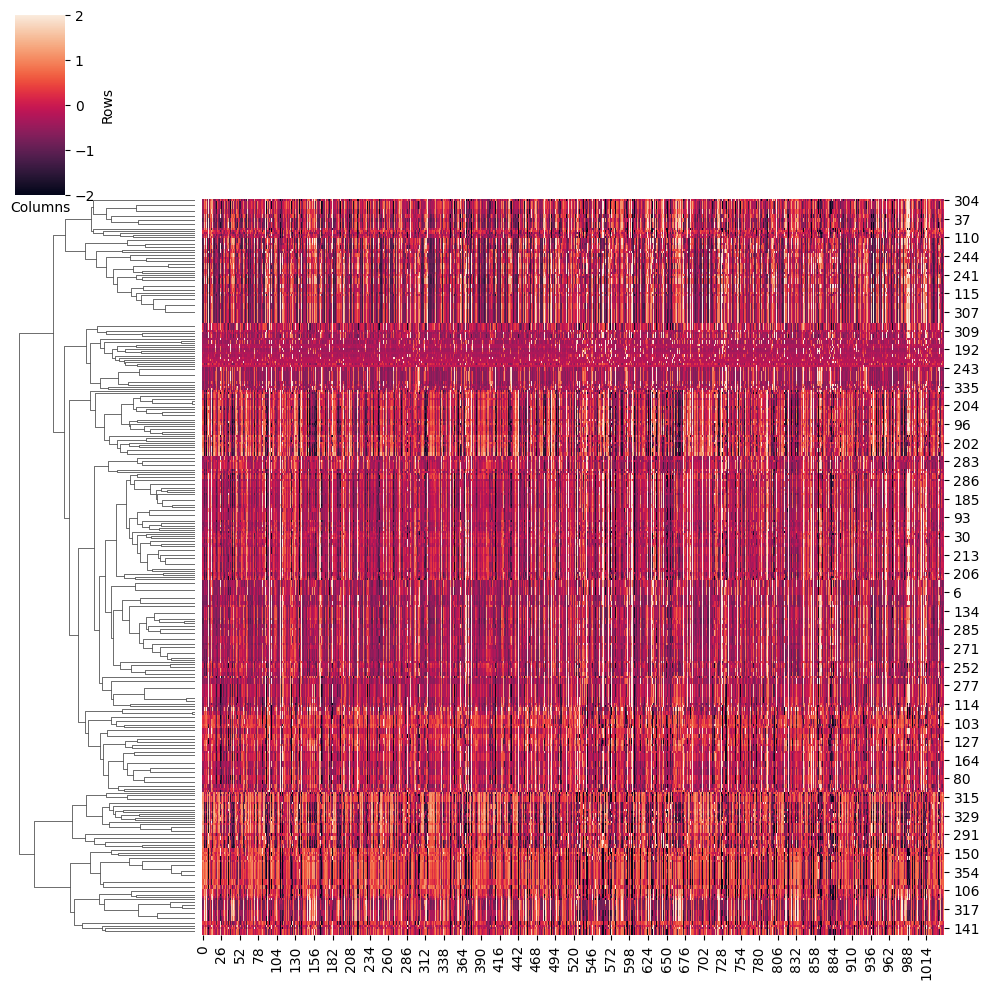

In [27]:
save=True
heatmap_cluster(TF_activity,adata_RNA,save,outdir)
#这里出的图和教程里面的确实不一样  但是横纵轴里面的数字代表什么意思还是不太明白

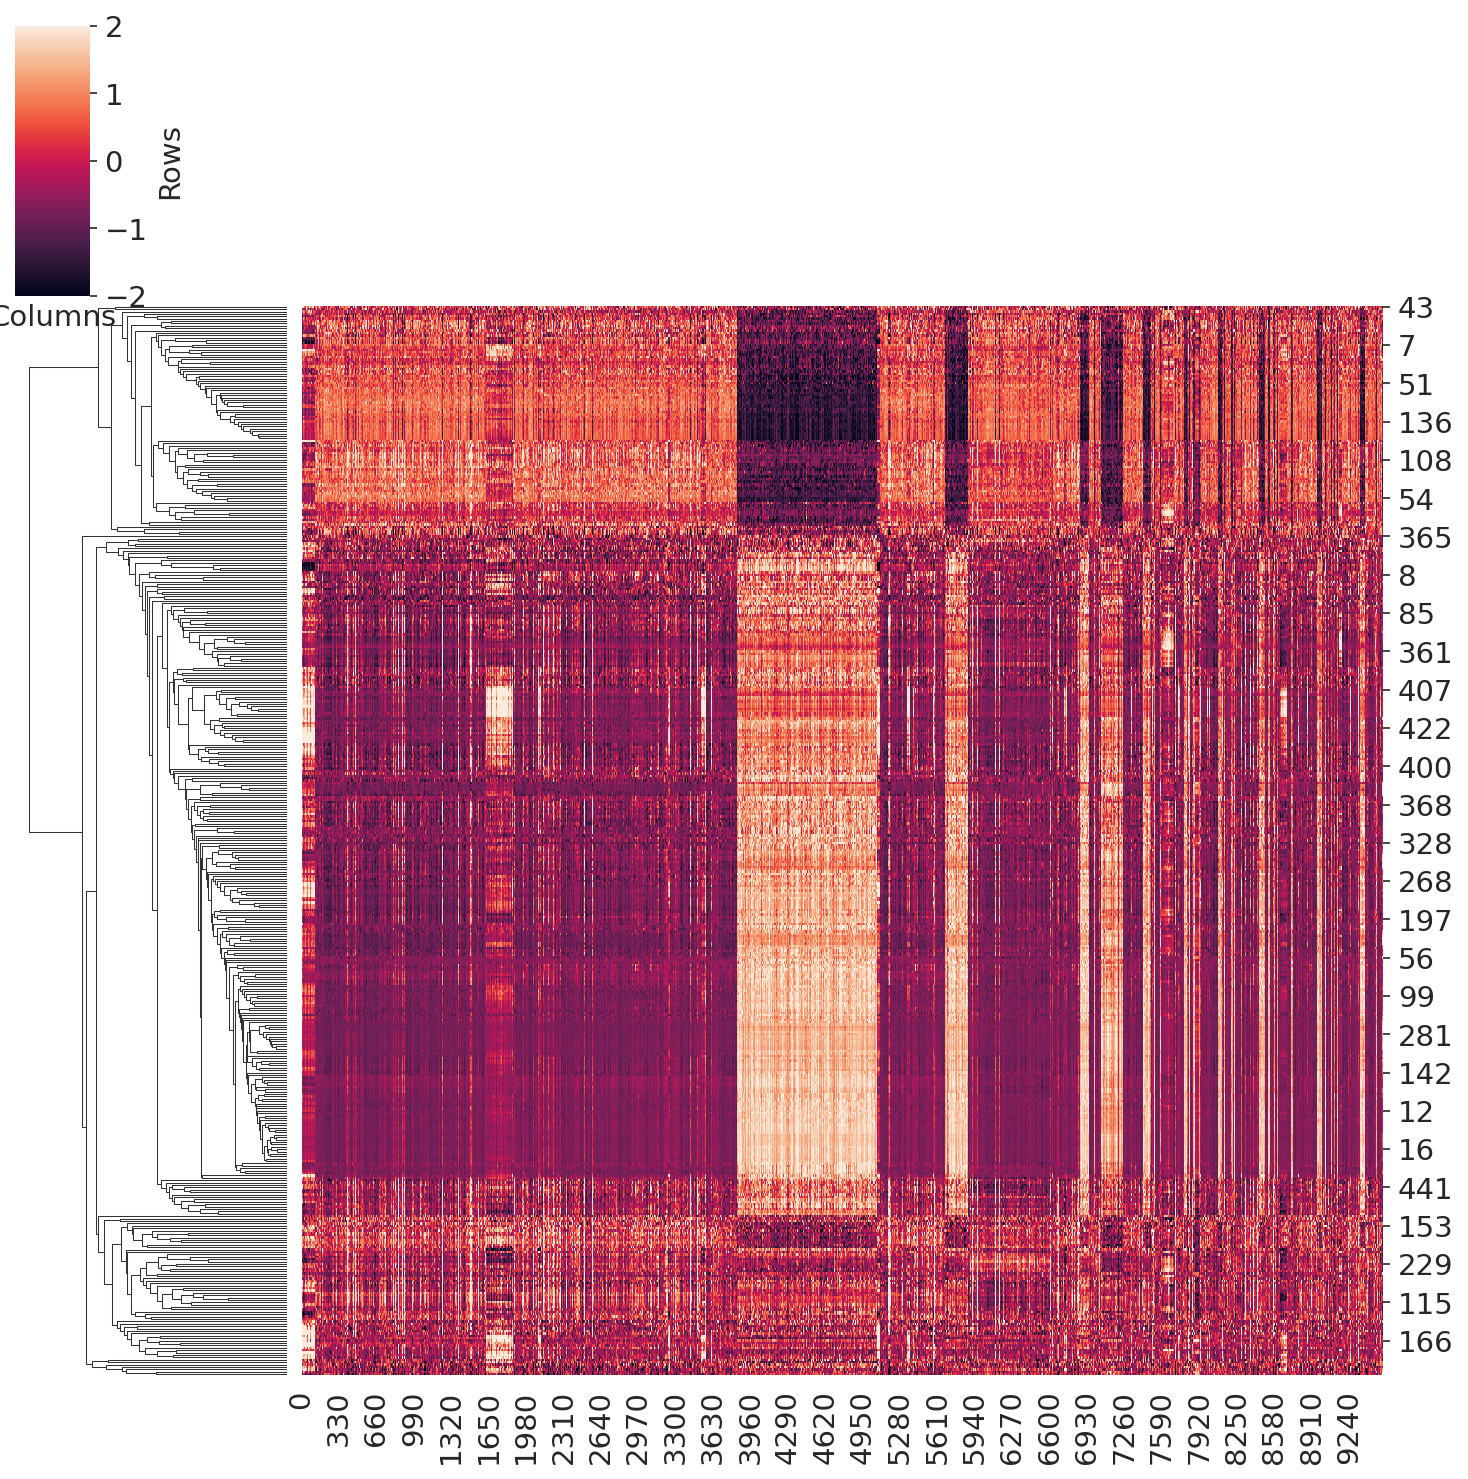

## Identify driver regulator
We use t-test to find the differential TFs of a certain cell type by the activity.

1. You can assign a certain cell type of the gene expression data by

In [28]:
celltype='0'

2. Or, you can obtain the result for all cell types.

In [ ]:
celltype='all'

For example,

In [29]:
celltype='0'
t_test_results=master_regulator(TF_activity,adata_RNA,celltype)
t_test_results

,t_stat,p_value,adj_p
GFI1B,2.077169,0.019016,0.120547
MAFF,-3.535059,0.999787,1.000000
HOXB3,-1.297046,0.902548,1.000000
MYCN,-0.680152,0.751720,1.000000
ETS2,-1.992646,0.976719,1.000000
...,...,...,...
ZBTB7B,3.720842,0.000105,0.003714
SOX13,-1.439255,0.924810,1.000000
PRDM14,-2.304558,0.989306,1.000000
EPAS1,1.347370,0.089078,0.419357


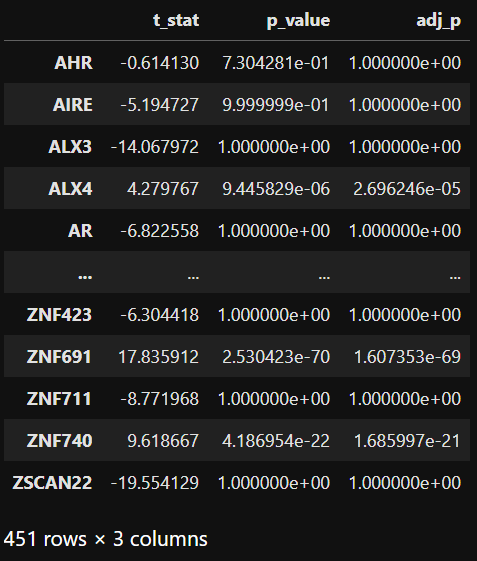

Visulize the differential activity and expression. You can compare 2 different cell types and one cell type with other cell types. If you want to save the heatmap to outdit, please set 'save=True'. The output is 'box_plot'+TFName+''+datatype+''+celltype1+''+celltype2+'.png'.  
细胞类型间比较

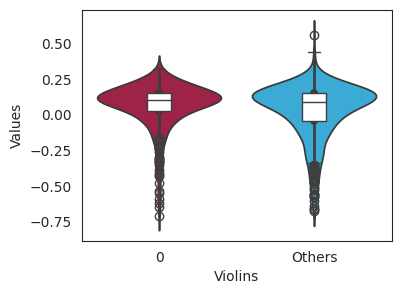

In [30]:
TFName='ATF1'  #必须是TF
datatype='activity'  #除了活性还有别的吗？
celltype1='0'
celltype2='Others'
save=True
box_comp(TFName,adata_RNA,celltype1,celltype2,datatype,TF_activity,save,outdir)

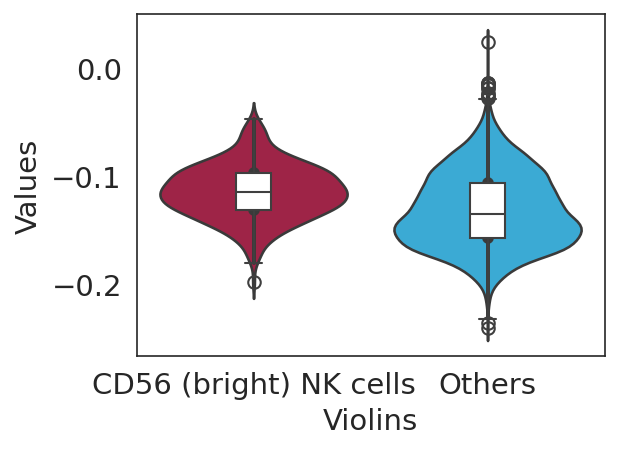

For gene expression data, the boxplot is:

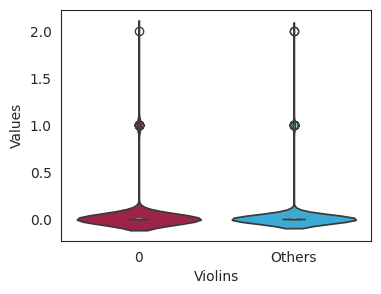

In [31]:
datatype='expression' #除了活性还有表达 那这优点拉跨
box_comp(TFName,adata_RNA,celltype1,celltype2,datatype,TF_activity,save,outdir)

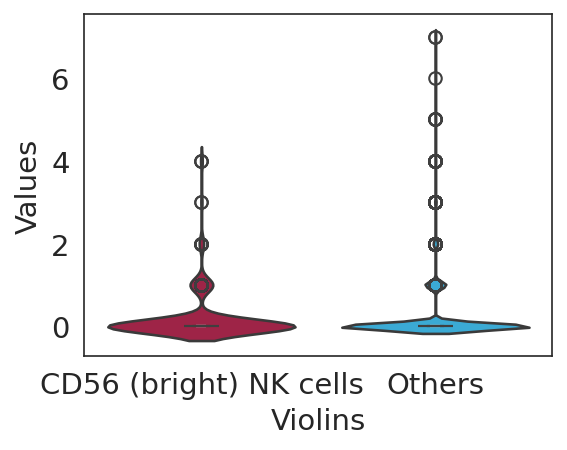

其实大部分都和PBMC的教程差不多